# Initial Set-Up

In [1]:
import pickle as pkl
import pandas as pd
import matplotlib
import os
import re

import collections
import datetime
import time

# import geopandas as gpd

import numpy as np

import rasterio

from difflib import get_close_matches

from fuzzywuzzy import process
from fuzzywuzzy import fuzz

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap


import seaborn as sns

import numpy as np

import scipy

from matplotlib.colors import LogNorm

from sklearn import preprocessing

import dask.dataframe as dd

import xclim


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
hq = pd.read_csv("../../data/companyData/justHQs.csv") 


min_lat = hq.latitude.min()
max_lat = hq.latitude.max()

min_lon = hq.longitude.min()
max_lon = hq.longitude.max()

In [3]:
'''baselineName = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/mirocHQs_198199.csv'
baseline = pd.read_csv(baselineName)'''

"baselineName = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/mirocHQs_198199.csv'\nbaseline = pd.read_csv(baselineName)"

# Weather Data
## *this is how we process the cmip6Data


In [4]:
import netCDF4 as nc
import xarray as xr

In [5]:
# https://kpegion.github.io/Pangeo-at-AOES/examples/advanced-analysis.html

In [6]:
def getAllData(weather,scenario):

    start = time.time()

    # weather = 'pr'
    file01 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/' + weather + '/' + weather + '_day_MIROC6_historical_r*9i1p1f1_gn_19800101-19891231.nc'
    file02 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/' + weather + '/' + weather + '_day_MIROC6_historical_r*9i1p1f1_gn_19900101-19991231.nc'
    file03 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/' + weather + '/' + weather + '_day_MIROC6_historical_r*9i1p1f1_gn_20000101-20091231.nc'
    file04 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/' + weather + '/' + weather + '_day_MIROC6_historical_r*9i1p1f1_gn_20100101-20141231.nc'

    data01 = xr.open_mfdataset(file01,concat_dim=['ensemble'],combine='nested',decode_times=True)
    data02 = xr.open_mfdataset(file02,concat_dim=['ensemble'],combine='nested',decode_times=True)
    data03 = xr.open_mfdataset(file03,concat_dim=['ensemble'],combine='nested',decode_times=True)
    data04 = xr.open_mfdataset(file04,concat_dim=['ensemble'],combine='nested',decode_times=True)


    file1 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/' + weather + '/' + weather + '_day_MIROC6_' + scenario + '_r*9i1p1f1_gn_20150101-20241231.nc'
    file2 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/' + weather + '/' + weather + '_day_MIROC6_' + scenario + '_r*9i1p1f1_gn_20250101-20341231.nc'
    file3 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/' + weather + '/' + weather + '_day_MIROC6_' + scenario + '_r*9i1p1f1_gn_20350101-20441231.nc'

    data1 = xr.open_mfdataset(file1,concat_dim=['ensemble'],combine='nested',decode_times=True)
    data2 = xr.open_mfdataset(file2,concat_dim=['ensemble'],combine='nested',decode_times=True)
    data3 = xr.open_mfdataset(file3,concat_dim=['ensemble'],combine='nested',decode_times=True)

    data = xr.combine_by_coords([data1,data2,data3,data01,data02,data03,data04])

    data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
    data = data.sortby(data.lon)

    data = data.sel(lat=slice(min_lat,max_lat), 
                    lon=slice(min_lon,max_lon),
                   time=slice('1981-01-01','2039-12-31'))

    data['time'] = pd.to_datetime(data.time.values.astype(str))
    
    print("starting to load")
    start = time.time()
    # data = data.compute(workers = 100)

    time.time() - start

    # , ,combine = 'by_coords')   #  nc.Dataset(file)

    print("ending the load: ", time.time() - start)

    return(data)

In [7]:
def getFutureData(weather,scenario):

    start = time.time()

    # weather = 'pr'


    file1 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/' + weather + '/' + weather + '_day_MIROC6_' + scenario + '_r*9i1p1f1_gn_20150101-20241231.nc'
    file2 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/' + weather + '/' + weather + '_day_MIROC6_' + scenario + '_r*9i1p1f1_gn_20250101-20341231.nc'
    file3 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/' + weather + '/' + weather + '_day_MIROC6_' + scenario + '_r*9i1p1f1_gn_20350101-20441231.nc'

    data1 = xr.open_mfdataset(file1,concat_dim=['ensemble'],combine='nested',decode_times=True)
    data2 = xr.open_mfdataset(file2,concat_dim=['ensemble'],combine='nested',decode_times=True)
    data3 = xr.open_mfdataset(file3,concat_dim=['ensemble'],combine='nested',decode_times=True)

    data = xr.combine_by_coords([data1,data2,data3])

    data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
    data = data.sortby(data.lon)

    data = data.sel(lat=slice(min_lat,max_lat), 
                    lon=slice(min_lon,max_lon),
                   time=slice('2019-01-01','2039-12-31'))

    data['time'] = pd.to_datetime(data.time.values.astype(str))
    
    print("starting to load")
    start = time.time()
    # data = data.compute(workers = 100)

    time.time() - start

    # , ,combine = 'by_coords')   #  nc.Dataset(file)

    print("ending the load: ", time.time() - start)

    return(data)

In [8]:
def getHistData(weather):

    start = time.time()

    # weather = 'pr'


    file1 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/' + weather + '/' + weather + '_day_MIROC6_historical_r*9i1p1f1_gn_19800101-19891231.nc'
    file2 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/' + weather + '/' + weather + '_day_MIROC6_historical_r*9i1p1f1_gn_19900101-19991231.nc'


    data1 = xr.open_mfdataset(file1,concat_dim=['ensemble'],combine='nested',decode_times=True)
    data2 = xr.open_mfdataset(file2,concat_dim=['ensemble'],combine='nested',decode_times=True)

    data = xr.combine_by_coords([data1,data2])

    data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
    data = data.sortby(data.lon)

    data = data.sel(lat=slice(min_lat,max_lat), 
                    lon=slice(min_lon,max_lon),
                   time=slice('1981-01-01','1999-12-31'))

    data['time'] = pd.to_datetime(data.time.values.astype(str))
    
    print("starting to load")
    start = time.time()
    data = data.compute(workers = 100)

    time.time() - start

    # , ,combine = 'by_coords')   #  nc.Dataset(file)

    print("ending the load: ", time.time() - start)

    return(data)

In [9]:
# this now for some reason seems to work
'''from xclim import ensembles
import glob

import xarray as xr

import xclim as xc
ens = ensembles.create_ensemble(glob.glob(file)).load()'''

'from xclim import ensembles\nimport glob\n\nimport xarray as xr\n\nimport xclim as xc\nens = ensembles.create_ensemble(glob.glob(file)).load()'

# Summaries
Summarize some of the data here.

### average weather by coords across ensemble and across time

In [12]:
tasmaxAll = getAllData('tasmax','ssp585')
tasmaxAll['tasmax'] = 1.8*(tasmaxAll.tasmax - 273) + 32

prAll     = getAllData('pr','ssp585')

starting to load
ending the load:  2.86102294921875e-06


In [34]:
start       = time.time()

overallTemp     = tasmaxAll.mean(dim = ['ensemble','lat','lon'])
overallMeanTemp = pd.Series(overallTemp.tasmax.values)
print(time.time() - start)


# find the standard deviation across all ensembles
overallStdTemp  = tasmaxAll.std(dim = ['ensemble','lat','lon'])
overallStdTemp  = pd.Series(tasmaxAll.mean(dim = ['lat',
                    'lon']).std(dim = ['ensemble']).tasmax.values)
print(time.time() - start)

39.62301182746887
77.33015394210815


In [52]:
rollingMean  = overallMeanTemp.rolling(365).mean()
rollingUpper = overallMeanTemp.rolling(365).mean() + 1.96*overallStdTemp.rolling(365).mean()
rollingLower = overallMeanTemp.rolling(365).mean() - 1.96*overallStdTemp.rolling(365).mean()

array(['1981-01-01T12:00:00.000000000', '1981-01-02T12:00:00.000000000',
       '1981-01-03T12:00:00.000000000', ...,
       '2039-12-29T12:00:00.000000000', '2039-12-30T12:00:00.000000000',
       '2039-12-31T12:00:00.000000000'], dtype='datetime64[ns]')

Text(0.5, 1.0, 'Temperature Mean Trend')

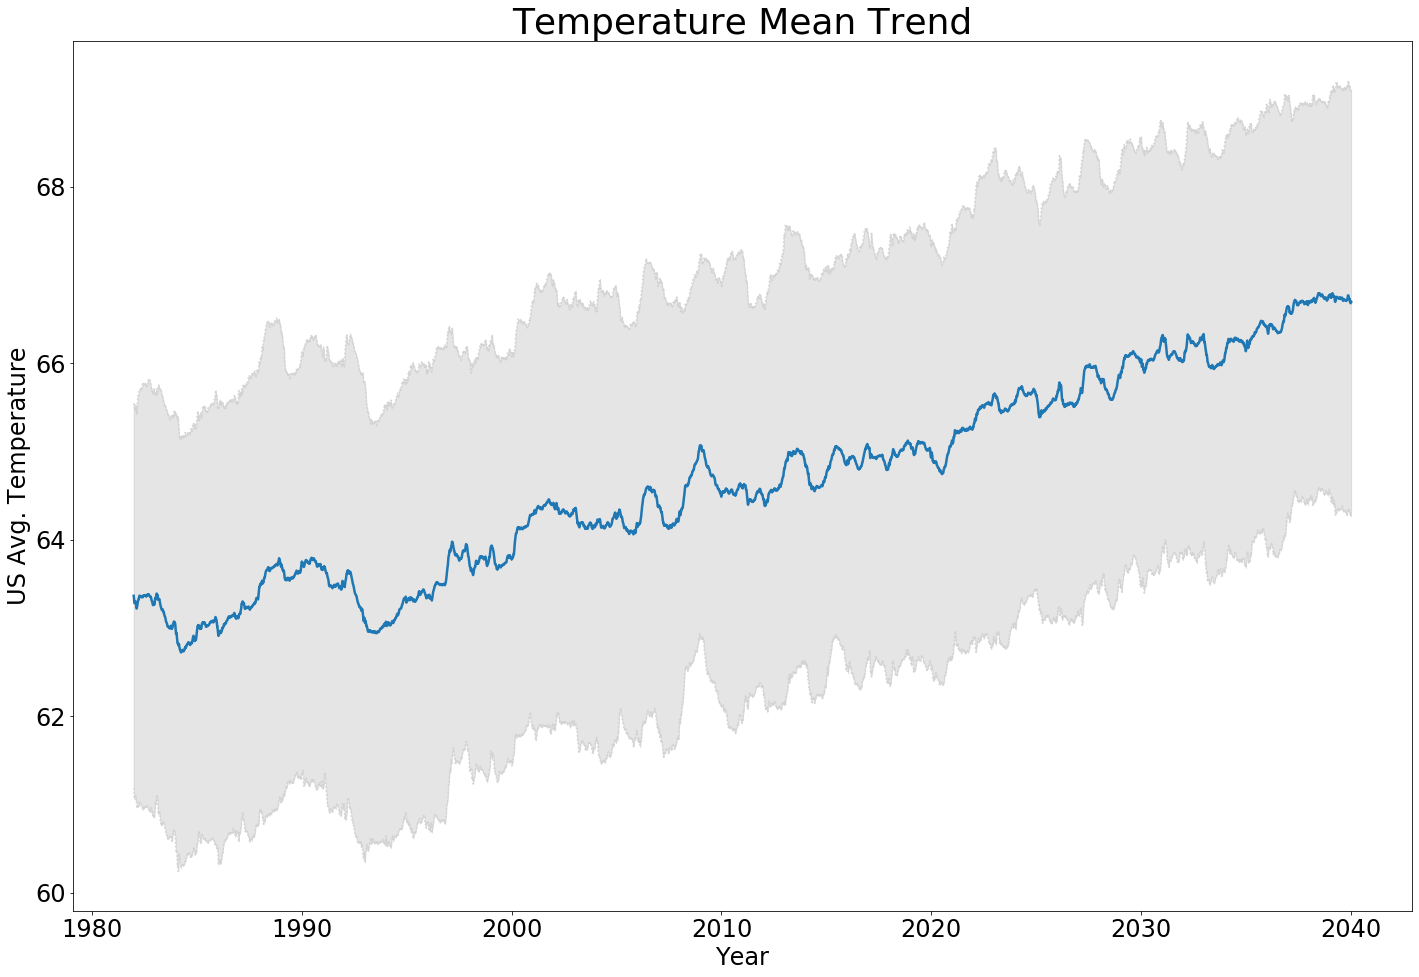

In [81]:
plt.figure(figsize = (24, 16))


time = tasmaxAll.time.values

plt.plot(time,rollingMean,linewidth = 2.5)
plt.plot(time,rollingUpper, color = 'lightgrey', linestyle = 'dotted')
plt.plot(time,rollingLower, color = 'lightgrey', linestyle = 'dotted')
plt.fill_between(time, rollingLower, rollingUpper, color='grey', alpha=.2)

plt.xlabel('Year', fontsize = 24)
plt.ylabel('US Avg. Temperature', fontsize = 24)
plt.rcParams['font.size'] = 18


plt.title("Temperature Mean Trend", 
          fontsize = 36)

In [15]:
outfile =  '../../data/companyData/miroc_historicalMean.pkl'
with open(outfile, 'wb') as pickle_file:
    pkl.dump(overallMean, pickle_file)
    
outfile =  '../../data/companyData/miroc_historicalStdDev.pkl'
with open(outfile, 'wb') as pickle_file:
    pkl.dump(overallStd, pickle_file)

In [ ]:
'''start       = time.time()


byCoord = data.mean(dim = ['ensemble','time'])
ensembleMeanByCoord = byCoord.pr.values

time.time() - start'''

## 95th percentile by ensemble
find percentile by quarter

In [10]:
tasmaxHist = getHistData('tasmax')
prHist = getHistData('pr')

starting to load
ending the load:  51.675349950790405
starting to load
ending the load:  69.28695702552795


### precipitation first
historical precipitation - 95th percentile

In [16]:
start                         = time.time()
pr95s = prHist.pr.groupby(prHist.time.dt.quarter).quantile(0.95, dim = ('time'))
time.time() - start

2.175743341445923

and future. load it, subtract off 95th percentile each quarter, and count the number of instances > 95th percentile

In [17]:
prFuture = getFutureData('pr','ssp585')

starting to load
ending the load:  1.1920928955078125e-06


In [98]:
prExtremes_q1 = (1*(prFuture.where(prFuture.time.dt.quarter == 1, drop = True).pr - 
     pr95s.where(pr95s.quarter == 1, drop = True)) > 0)

prQ1Avg = prExtremes_q1.groupby(prExtremes_q1.time.dt.year).\
    sum(dim = ['time','quarter']).mean(dim = ['year','ensemble']).compute(workers = 100)


### q2 
prExtremes_q2 = (1*(prFuture.where(prFuture.time.dt.quarter == 2, drop = True).pr - 
     pr95s.where(pr95s.quarter == 2, drop = True)) > 0)

prQ2Avg = prExtremes_q2.groupby(prExtremes_q2.time.dt.year).\
    sum(dim = ['time','quarter']).mean(dim = ['year','ensemble']).compute(workers = 100)



### q3 
prExtremes_q3 = (1*(prFuture.where(prFuture.time.dt.quarter == 3, drop = True).pr - 
     pr95s.where(pr95s.quarter == 3, drop = True)) > 0)

prQ3Avg = prExtremes_q3.groupby(prExtremes_q3.time.dt.year).\
    sum(dim = ['time','quarter']).mean(dim = ['year','ensemble']).compute(workers = 100)



### q4
prExtremes_q4 = (1*(prFuture.where(prFuture.time.dt.quarter == 4, drop = True).pr - 
     pr95s.where(pr95s.quarter == 4, drop = True)) > 0)

prQ4Avg = prExtremes_q4.groupby(prExtremes_q4.time.dt.year).\
    sum(dim = ['time','quarter']).mean(dim = ['year','ensemble']).compute(workers = 100)


### temperature next

In [171]:
tasmaxHist['tasmax_F'] = 1.8*(tasmaxHist['tasmax']-273) + 32
tasmaxHist['extreme']  = 1*(tasmaxHist['tasmax_F'] > 90)
tasmaxHist['extreme']

<xarray.DataArray 'extreme' (ensemble: 5, time: 6939, lat: 25, lon: 64)>
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],

In [181]:
tasmaxHist_q1 = tasmaxHist.where(tasmaxHist.time.dt.quarter == 1, drop = True).extreme
tasmaxHist_q1_90s = tasmaxHist_q1.groupby(tasmaxHist_q1.time.dt.year).\
    sum(dim = ['time']).mean(dim = ['year','ensemble']).compute(workers = 100)

tasmaxHist_q2 = tasmaxHist.where(tasmaxHist.time.dt.quarter == 2, drop = True).extreme
tasmaxHist_q2_90s = tasmaxHist_q2.groupby(tasmaxHist_q2.time.dt.year).\
    sum(dim = ['time']).mean(dim = ['year','ensemble']).compute(workers = 100)

tasmaxHist_q3 = tasmaxHist.where(tasmaxHist.time.dt.quarter == 3, drop = True).extreme
tasmaxHist_q3_90s = tasmaxHist_q3.groupby(tasmaxHist_q3.time.dt.year).\
    sum(dim = ['time']).mean(dim = ['year','ensemble']).compute(workers = 100)

tasmaxHist_q4 = tasmaxHist.where(tasmaxHist.time.dt.quarter == 4, drop = True).extreme
tasmaxHist_q4_90s = tasmaxHist_q4.groupby(tasmaxHist_q4.time.dt.year).\
    sum(dim = ['time']).mean(dim = ['year','ensemble']).compute(workers = 100)


In [191]:
tasmaxFuture = getFutureData('tasmax','ssp585')
tasmaxFuture['tasmax_F'] = 1.8*(tasmaxFuture['tasmax']-273) + 32
tasmaxFuture['extreme']  = 1*(tasmaxFuture.tasmax_F > 90)


tasmaxFuture_q1 = tasmaxFuture.where(tasmaxFuture.time.dt.quarter == 1, drop = True).extreme
tasmaxFuture_q1_90s = tasmaxFuture_q1.groupby(tasmaxFuture_q1.time.dt.year).\
    sum(dim = ['time']).mean(dim = ['year','ensemble']).compute(workers = 100) - tasmaxHist_q1_90s
print('q1 done')

tasmaxFuture_q2 = tasmaxFuture.where(tasmaxFuture.time.dt.quarter == 2, drop = True).extreme
tasmaxFuture_q2_90s = tasmaxFuture_q2.groupby(tasmaxFuture_q2.time.dt.year).\
    sum(dim = ['time']).mean(dim = ['year','ensemble']).compute(workers = 100) - tasmaxHist_q2_90s
print('q2 done')

tasmaxFuture_q3 = tasmaxFuture.where(tasmaxFuture.time.dt.quarter == 3, drop = True).extreme
tasmaxFuture_q3_90s = tasmaxFuture_q3.groupby(tasmaxFuture_q3.time.dt.year).\
    sum(dim = ['time']).mean(dim = ['year','ensemble']).compute(workers = 100) - tasmaxHist_q3_90s
print('q3 done')

tasmaxFuture_q4 = tasmaxFuture.where(tasmaxFuture.time.dt.quarter == 4, drop = True).extreme
tasmaxFuture_q4_90s = tasmaxFuture_q4.groupby(tasmaxFuture_q4.time.dt.year).\
    sum(dim = ['time']).mean(dim = ['year','ensemble']).compute(workers = 100) - - tasmaxHist_q4_90s
print('q4 done')


starting to load
ending the load:  0.0


## Merge Everything In
Currently we have the hqs in hqtest

In [140]:
hqTest = hq.head()[['zipcode','latitude','longitude']].rename(columns = {'latitude': 'lat',
                                                               'longitude': 'lon'})

In [196]:
def findClosest(row):
    closestVal_pr1 = prQ1Avg.sel(lat=row.lat, lon=row.lon, method = 'nearest').values
    closestVal_pr2 = prQ2Avg.sel(lat=row.lat, lon=row.lon, method = 'nearest').values
    closestVal_pr3 = prQ3Avg.sel(lat=row.lat, lon=row.lon, method = 'nearest').values
    closestVal_pr4 = prQ4Avg.sel(lat=row.lat, lon=row.lon, method = 'nearest').values
    
    closestVal_tasmax1 = tasmaxFuture_q1_90s.sel(lat=row.lat, lon=row.lon, method = 'nearest').values
    closestVal_tasmax2 = tasmaxFuture_q2_90s.sel(lat=row.lat, lon=row.lon, method = 'nearest').values
    closestVal_tasmax3 = tasmaxFuture_q3_90s.sel(lat=row.lat, lon=row.lon, method = 'nearest').values
    closestVal_tasmax4 = tasmaxFuture_q4_90s.sel(lat=row.lat, lon=row.lon, method = 'nearest').values
    

    
    return(closestVal_pr1.item(), closestVal_pr2.item(), closestVal_pr3.item(), closestVal_pr4.item(),
          closestVal_tasmax1.item(), closestVal_tasmax2.item(), closestVal_tasmax3.item(), closestVal_tasmax4.item(),)

# item = findClosest(hqTest.iloc[0,:],prQ4Avg)
allQuarters        = hqTest.apply(findClosest, axis=1)


hqTest[['pr_q1', 'pr_q2', 'pr_q3', 'pr_q4',
       'tasmax_q1', 'tasmax_q2', 'tasmax_q3', 'tasmax_q4']] = pd.DataFrame(allQuarters.tolist(), index=allQuarters.index)


preds = pd.melt(hqTest, 
        id_vars = ['zipcode','lat','lon'],
        value_vars = hqTest.columns[3:],
       value_name = 'extremePred')


preds[['variable','quarter']] = preds.variable.str.split('_',expand=True)

preds


,zipcode,lat,lon,variable,extremePred,quarter
0,44146,41.41278,-81.50616,pr,5.104762,q1
1,85260,33.61963,-111.90171,pr,4.361905,q1
2,8876,40.59778,-74.69065,pr,4.933333,q1
3,60411,41.52176,-87.61784,pr,5.247619,q1
4,74102,36.15089,-95.99398,pr,4.752381,q1
5,44146,41.41278,-81.50616,pr,4.809524,q2
6,85260,33.61963,-111.90171,pr,3.828571,q2
7,8876,40.59778,-74.69065,pr,5.228571,q2
8,60411,41.52176,-87.61784,pr,4.552381,q2
9,74102,36.15089,-95.99398,pr,4.695238,q2


In [199]:
preds.pivot(index=['zipcode','lat','lon', 'quarter'], columns='variable', values='extremePred')

variable                                   pr     tasmax
zipcode lat      lon        quarter                     
8876    40.59778 -74.69065  q1       4.933333   0.000000
                            q2       5.228571   3.705263
                            q3       5.609524  11.337343
                            q4       4.523810   0.028571
44146   41.41278 -81.50616  q1       5.104762   0.000000
                            q2       4.809524   3.535338
                            q3       5.152381  10.600000
                            q4       4.828571   0.000000
60411   41.52176 -87.61784  q1       5.247619   0.000000
                            q2       4.552381   5.040100
                            q3       4.514286  11.092732
                            q4       4.819048   0.009524
74102   36.15089 -95.99398  q1       4.752381   0.049123
                            q2       4.695238   9.516792
                            q3       4.638095   7.685714
                            q4       4.209524   7.336842
85260   33.61963 -111.90171 q1       4.361905   0.468672
                            q2       3.828571   6.789474
                            q3       6.485714   0.239098
                            q4       4.190476  33.754887

In [ ]:
tasmaxAll.mean(dim = ['lat',
                    'lon']).std(dim = ['ensemble']).tasmax.values

In [51]:
q1Future = prFuture.where(prFuture.time.dt.quarter == 1)

In [58]:
q1Future.pr.where(prFuture.time.dt.quarter == 1, drop = True) - 

<xarray.DataArray 'pr' (ensemble: 5, time: 1895, lat: 25, lon: 64)>
dask.array<where, shape=(5, 1895, 25, 64), dtype=float32, chunksize=(1, 902, 25, 64), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -157.5 -156.1 -154.7 -153.3 ... -71.72 -70.31 -68.91
  * lat      (lat) float64 21.71 23.11 24.51 25.91 ... 51.13 52.53 53.93 55.33
  * time     (time) datetime64[ns] 2019-01-01T12:00:00 ... 2039-03-31T12:00:00
Dimensions without coordinates: ensemble
Attributes:
    standard_name:   precipitation_flux
    long_name:       Precipitation
    comment:         includes both liquid and solid phases
    units:           kg m-2 s-1
    original_name:   PRCP
    original_units:  kg/m**2/s
    cell_methods:    area: time: mean
    cell_measures:   area: areacella

In [55]:
tasmax_future.groupby(pr_future.time.dt.quarter).mean(dim = ['ensemble','time'])

NameError: name 'quarter' is not defined

## tasmax - future

starting to load
ending the load:  1.1920928955078125e-06


In [124]:
futureTempExtremes.extreme.data


dask.array<concatenate, shape=(4, 25, 64), dtype=float64, chunksize=(1, 25, 64), chunktype=numpy.ndarray>

In [47]:
start                         = time.time()
percentileByQuarterByEnsemble = pr.groupby(pr.time.dt.quarter).quantile(0.95, dim = ('time'))
# percentileByEnsemble        = data.quantile(0.95, dim = ('time'))
time.time() - start

21.77485179901123

alternatives: can do percentiles on a per-ensemble basis, too.

In [17]:
outfile =  '../../data/companyData/miroc_historical95s.pkl'
with open(outfile, 'wb') as pickle_file:
    pkl.dump(percentileByEnsemble, pickle_file)

------------------------------

# Code Graveyard




In [97]:
weather = 'pr'
scenario = 'ssp585'

file1 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/' + weather + '/' + weather + '_day_MIROC6_' + scenario + '_r*i1p1f1_gn_20150101-20241231.nc'
file2 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/' + weather + '/' + weather + '_day_MIROC6_' + scenario + '_r*i1p1f1_gn_20250101-20341231.nc'
file3 = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/' + weather + '/' + weather + '_day_MIROC6_' + scenario + '_r*i1p1f1_gn_20350101-20441231.nc'

data1 = xr.open_mfdataset(file1,concat_dim=['ensemble'],combine='nested',decode_times=True)
data2 = xr.open_mfdataset(file2,concat_dim=['ensemble'],combine='nested',decode_times=True)
data3 = xr.open_mfdataset(file3,concat_dim=['ensemble'],combine='nested',decode_times=True)

data = xr.combine_by_coords([data1,data2,data3])

In [ ]:
file = open('../../data/companyData/miroc_historical95s.pkl','rb')
percentileByEnsemble = pkl.load(file)

In [ ]:
percentileByEnsemble

In [ ]:
# numpy and xarray and all that
# https://www.earthinversion.com/utilities/reading-NetCDF4-data-in-python/

In [ ]:
data.ensemble == 1

In [ ]:
# https://metview.readthedocs.io/en/latest/examples/ens_mean_spread_xarray.html
# data.mean(dim = 'ensemble')
overall = data.mean(dim = ['lat','lon'])
overall.pr.plot(hue = 'ensemble')

In [ ]:
plt.style.use("seaborn-dark")
plt.rcParams["figure.figsize"] = (13, 5)
ens.tas.plot(hue="realization")
plt.show()

In [ ]:
# this takes the ensemble mean and then the mean over time
data_emean = data.mean()# .mean() 
print(data_emean)

In [ ]:
import glob

import xarray as xr

import xclim as xc

# Set display to HTML sytle (for fancy output)
xr.set_options(display_style="html", display_width=50)

import matplotlib.pyplot as plt

%matplotlib inline

from xclim import ensembles

In [ ]:
len(glob.glob('../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/pr/pr_day_MIROC6_historical_r1*i1p1f1_gn_19800101-19891231.nc'))
datasets = glob.glob('../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/pr/pr_day_MIROC6_historical_r1*i1p1f1_gn_19800101-19891231.nc')
datasets

In [ ]:
# file = 
# data = xr.open_mfdataset(file,concat_dim='ensemble',combine='nested',decode_times=True)

ens = ensembles.create_ensemble(datasets, mf_flag = True)

In [ ]:
geoHQ = gpd.GeoDataFrame(
    allIG,
    geometry=gpd.points_from_xy(
        allIG["longitude"],
        allIG["latitude"],
    ),
    crs={"init":"EPSG:4326"},
)

In [ ]:
one_point = data["pr"].sel(lat=50, lon=50)

In [ ]:
pd.DataFrame(test.temperature[test.year == 2010]).plot()

Now go through and make this iterable for the entire list.

In [ ]:
i = 0
data.pr.sel(allIG.iloc[0,:], method='nearest')

In [ ]:
hqPost2010 = geoHQ[geoHQ.archive_version_year > 2010].reset_index()

In [ ]:
start = time.time()



tempsList = list()
for i in range(0,hqPost2010.shape[0]):
    nearbyTemps = temps.sel(hqPost2010.loc[i,['latitude','longitude']], method='nearest')
    
    tempsList.append(list(np.array(nearbyTemps.temperature[nearbyTemps.year == hqPost2010.archive_version_year[i]])))

    if (i%100 == 0):
        print(i)
    
print(time.time() - start)






In [ ]:
outfile =  'data/hqDailyTemperatures.pkl'
with open(outfile, 'wb') as pickle_file:
    pickle.dump(tempsList, pickle_file)

# Now let's do the percentiles

In [ ]:
baselineName = '../../../../../../../Volumes/backup2/dissData/cmip6Data/hist/mirocHQs_198199.csv'
baseline = pd.read_csv(baselineName)

In [ ]:
baseline.s.unique()

In [ ]:
baseline[baseline.variable == 'tasmax_hist']

In [ ]:
quantsPrecip   = baseline[baseline.variable == 'pr_hist'][['zipcode','variable','quarter','value']].\
    groupby(['zipcode','variable','quarter']).quantile(.95).reset_index()
quantsPrecip.rename(columns = {'value': 'quantCutoff'}, inplace = True)
quantsPrecip['daysExtreme'] = 4.5


In [ ]:
quantsPrecip.head()

Find number of days above 90F.

In [ ]:
temp = baseline[baseline.variable == 'tasmax_hist'].drop(columns = {'s','year'})
temp.head()

In [ ]:
quantsTemp = baseline[baseline.variable == 'tasmax_hist'].drop(columns = {'s','year'})
quantsTemp['daysExtreme'] = 1*(quantsTemp.value > 305.3)
quantsTemp = quantsTemp.groupby(['zipcode', 'variable', 'quarter']).median().reset_index()
quantsTemp.rename(columns = {'value': 'quantCutoff'}, inplace = True)

quantsTemp.daysExtreme = quantsTemp.daysExtreme*90
quantsTemp.quantCutoff = 305.3


quantsTemp.head()

In [ ]:
quantsPrecip.head()

In [ ]:
quants = quantsPrecip.append(quantsTemp)

In [ ]:
quants.head()

And apply them to the next period.

In [ ]:
nextPeriodName = '../../../../../../../Volumes/backup2/dissData/cmip6Data/proj/mirocHQs_202040.csv'
nextPeriod = pd.read_csv(nextPeriodName)# .drop(columns = ['s'])

In [ ]:
nextPeriod.shape[0]/len(nextPeriod.zipcode.unique())/365/18/2/4

In [ ]:
nextPeriod.head()

In [ ]:
quants.daysExtreme

In [ ]:
nextPeriod = nextPeriod.merge(quants)
nextPeriod.head()

In [ ]:
nextPeriod['extreme'] = 1*(nextPeriod.value > nextPeriod.quantCutoff)

In [ ]:
# nextPeriod.to_csv("../../data/companyData/nextPeriodExtremes.csv")

In [ ]:
nextPeriod.head()

In [ ]:
nextPeriod.year

In [ ]:
nextPeriod['yearQuarter'] = nextPeriod.year.astype('int64') + nextPeriod.quarter.str[1:2].astype('int64')/4

In [ ]:
nextPeriod.head()

In [ ]:
nextPeriod[['zipcode']].drop_duplicates().shape

In [ ]:
nextPeriod.head()

In [ ]:
nextPeriod[nextPeriod.variable == 'pr_hist'].extreme.describe()

In [ ]:
quarterlyExtremes = nextPeriod[['variable','s','year','quarter','yearQuarter','zipcode','extreme']].\
    groupby(['variable','s','year','quarter','yearQuarter','zipcode']).sum().reset_index()

In [ ]:
zipLats = pd.read_csv("../../data/companyData/quarterlyExtremesMean.csv")[['zipcode','latitude','longitude']].\
    groupby(['zipcode']).mean().reset_index()

quarterlyExtremes = quarterlyExtremes.merge(zipLats)

In [ ]:
quarterlyExtremes.head()

In [ ]:
quarterlyExtremes.head()

In [ ]:
quarterlyExtremes.to_csv("../../data/companyData/quarterlyExtremesAll.csv")

In [ ]:
quarterlyExtremesMean = quarterlyExtremes[['variable','quarter','zipcode','latitude','longitude','extreme']].\
    groupby(['variable','quarter','zipcode','latitude','longitude']).mean().reset_index()

In [ ]:
quarterlyExtremesMean[quarterlyExtremesMean.variable == 'tasmax_hist'].extreme.describe()

In [ ]:
quarterlyExtremesMean[quarterlyExtremesMean.variable == 'pr_hist'].extreme.describe()

In [ ]:
quarterlyExtremesMean.head()

In [ ]:
quarterlyExtremesMean = quarterlyExtremesMean.merge(quants[['zipcode','variable','quarter','daysExtreme']])
quarterlyExtremesMean.head()

In [ ]:
quarterlyExtremesMean.to_csv("../../data/companyData/quarterlyExtremesMean.csv")

In [ ]:
zipLats.head()

In [ ]:
quarterlyExtremesMean.groupby(['variable']).extreme.describe()

------------------------------

In [ ]:
# we might have multiple records from within the same zipcode
quarterlyExtremesMean = quarterlyExtremes[['variable','quarter','zipcode','extreme']].\
    groupby(['variable','quarter','zipcode']).mean().reset_index()

# .groupby(['variable','quarter','zipcode']).mean().reset_index()


In [ ]:
quarterlyExtremesMean.groupby('variable').extreme.hist(bins = 100)

In [ ]:
(quarterlyExtremesMean[quarterlyExtremesMean.variable == 'tasmax_hist'].extreme - 4.5).hist(bins = 100)

In [ ]:
(quarterlyExtremesMean[quarterlyExtremesMean.variable == 'pr_hist'].extreme - 4.5).hist(bins = 100)

In [ ]:
sum(quarterlyExtremesMean[quarterlyExtremesMean.variable == 'pr_hist'].extreme > 4.5)/quarterlyExtremesMean[quarterlyExtremesMean.variable == 'pr_hist'].shape[0]

In [ ]:
sum(quarterlyExtremesMean[quarterlyExtremesMean.variable == 'tasmax_hist'].\
    extreme > 4.5)/quarterlyExtremesMean[quarterlyExtremesMean.variable == 'tasmax_hist'].shape[0]